# 0. IMPORT DEPENDENCIES

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

from data_plot import *


# 1. DATA PRE-PROCESSING


In [2]:
df = pd.read_excel("./data/dining area.xlsx")
df.head(3)

,Unnamed: 0,epochtime,datatype,value,unit,control,min_value,max_value
0,0,2022-04-22 22:05:00,temperature,22.1,Celcius,indirect,NaN,NaN
1,1,2022-04-22 22:05:00,luminosity,0.0,Lux,indirect,0.0,NaN
2,2,2022-04-22 22:05:00,humidity,49.0,%,indirect,0.0,100.0


In [3]:
df.duplicated().sum()

np.int64(0)

In [4]:
print(f"Trước khi xử lý: {df.shape}")

df.drop_duplicates(inplace = True)
print(f"Sau khi xử lý: {df.shape}")

Trước khi xử lý: (155260, 8)
Sau khi xử lý: (155260, 8)


## 1.1. Chuyển đổi, thống nhất đơn vị giá trị



### 1.1.1 Chuyển hóa, thống nhất đơn vị datatype

In [5]:
datatypes = df["datatype"].unique()
for datatype in datatypes:
    rows = df[df["datatype"] == datatype]
    units = rows["unit"].unique()
    controls = rows["control"].unique()
    print(f"Dữ liệu loại {datatype} có:")
    print(" - Unit:")
    print("\n".join(f"          + {unit}" for unit in units))
    print(" - Control:")
    print("\n".join(f"          + {control}" for control in controls))
    print()

Dữ liệu loại temperature có:
 - Unit:
          + Celcius
 - Control:
          + indirect
          + direct

Dữ liệu loại luminosity có:
 - Unit:
          + Lux
 - Control:
          + indirect

Dữ liệu loại humidity có:
 - Unit:
          + %
 - Control:
          + indirect

Dữ liệu loại motion có:
 - Unit:
          + nan
 - Control:
          + no

Dữ liệu loại acoustic có:
 - Unit:
          + dBm
 - Control:
          + indirect



Có thể thấy:
- `Temperature` hay `Nhiệt độ`: 
    - `Unit`: `Celsius`
    - `Control`: `indirect`, `direct`

- `Luminosity` hay `Độ sáng`:
    - `Unit`: `Lux`
    - `Control`: `indirect`

- `Humidity` hay `Độ ẩm `:
    - `Unit`: `%`
    - `Control`: `indirect`
  
- `Motion` hay `Chuyển động`:
    - `Unit`: không có do `Motion` thể hiện tại thời điểm đó, zone có người hay không có người
    - `Control`: `no`
  
- `Acoustic` hay `Tiếng ồn `:
    - `Unit`: `dBm`
    - `Control`: `indirect`.

Do các loại dữ liệu không có nhiều hơn 1 kiểu đơn vị nên không cần thống nhất đơn vị.

### 1.2. Chuyển hóa dữ liệu Epochtime thành dữ liệu datetime

In [6]:
def str2datetime(epochtime):
    return datetime.strptime(epochtime, '%Y-%m-%d %H:%M:%S')

In [7]:
df["epochtime"] = df["epochtime"].apply(str2datetime)
df.head(2)

,Unnamed: 0,epochtime,datatype,value,unit,control,min_value,max_value
0,0,2022-04-22 22:05:00,temperature,22.1,Celcius,indirect,NaN,NaN
1,1,2022-04-22 22:05:00,luminosity,0.0,Lux,indirect,0.0,NaN


## 2.1. Kiểm tra giá trị bất thường

Giá trị bất thường là giá trị `value` mà không nằm trong khoảng [`min_value`, `max_value`].

- `pd.tonumeric(df, errors)`: Chuyển đổi một df thành các giá trị số.
  - `df`: DataFrame cần chuyển đổi.
  - `errors`: có 3 mode:
    - `raise` (mặc định): Nếu có giá trị không hợp lệ, nó sẽ báo lỗi.
    - `coerce`: Chuyển các giá trị không hợp lệ thành NaN.
    - `ignore`: Giữ nguyên các giá trị không hợp lệ mà không báo lỗi.

In [8]:
df["min_value"] = pd.to_numeric(df["min_value"], errors="coerce")
df["max_value"] = pd.to_numeric(df["max_value"], errors="coerce")

In [9]:
print(f"df trước khi kiểm tra: {df.shape}")
removed_outliner = df[
    ((df["value"] >= df["min_value"]) | df["min_value"].isna()) &
    ((df["value"] <= df["max_value"]) | df["max_value"].isna())
].reset_index(drop = True)

print(f"df sau khi kiểm tra: {removed_outliner.shape}")

df trước khi kiểm tra: (155260, 8)
df sau khi kiểm tra: (142412, 8)


In [10]:
outliners = df[
    ((df["value"] < df["min_value"]) & df["min_value"].notna()) |
    ((df["value"] > df["max_value"]) & df["max_value"].notna())
]

In [11]:
for datatype in outliners["datatype"].unique():
    print(f"{datatype} outliners:")
    print(
        outliners[
            (outliners["datatype"] == datatype)
        ].tail(5)
    , end = "\n\n")

acoustic outliners:
        Unnamed: 0           epochtime  datatype  value unit   control  \
155241      155241 2024-08-05 10:35:00  acoustic  -89.0  dBm  indirect   
155245      155245 2024-08-05 10:55:00  acoustic  -89.0  dBm  indirect   
155248      155248 2024-08-05 11:10:00  acoustic  -91.0  dBm  indirect   
155251      155251 2024-08-05 11:30:00  acoustic  -89.0  dBm  indirect   
155258      155258 2024-08-05 11:50:00  acoustic  -89.0  dBm  indirect   

        min_value  max_value  
155241        0.0        NaN  
155245        0.0        NaN  
155248        0.0        NaN  
155251        0.0        NaN  
155258        0.0        NaN  

luminosity outliners:
       Unnamed: 0           epochtime    datatype      value unit   control  \
86417       86417 2023-04-21 11:09:53  luminosity -23.623500  Lux  indirect   
86427       86427 2023-04-21 11:10:23  luminosity -11.742786  Lux  indirect   
86429       86429 2023-04-21 11:10:23  luminosity -71.205476  Lux  indirect   
86441     

## 2.3. Data segmentation

### 2.3.1. Kiểm tra số lượng mẫu dữ liệu

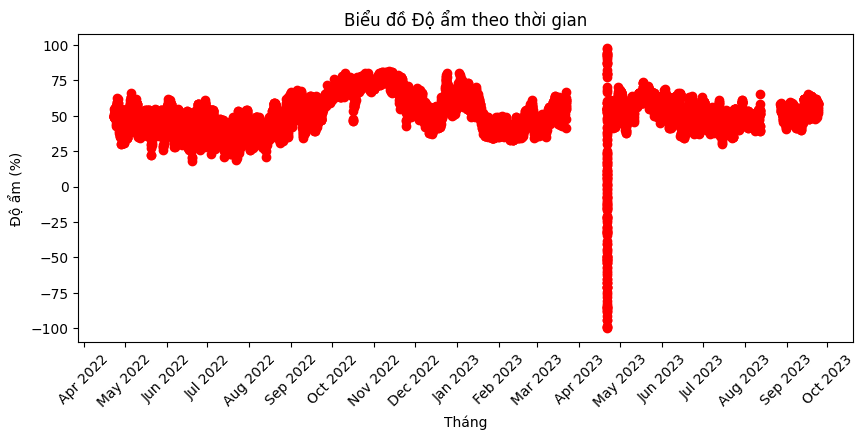

In [12]:
humidity_rows = df[
    df["datatype"] == "humidity"
]

time, value = humidity_rows["epochtime"], humidity_rows["value"]
lineplot(time, value, {"datatype": "Độ ẩm", "unit": "%"})

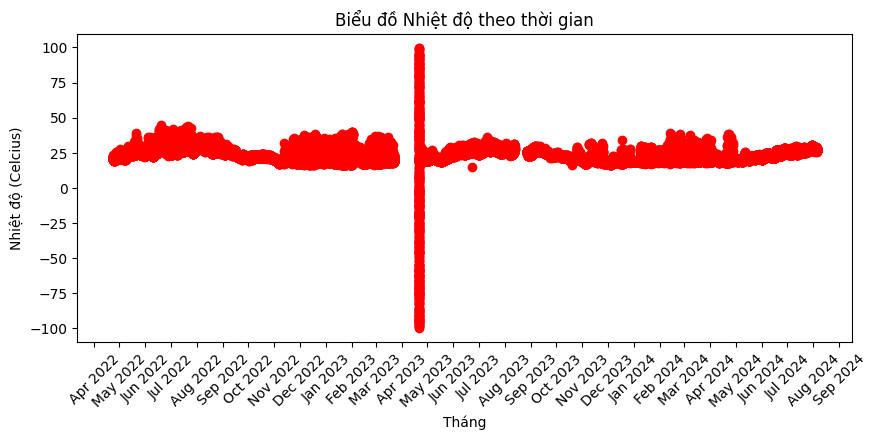

In [13]:
temperature_rows = df[
    df["datatype"] == "temperature"
]

time, value = temperature_rows["epochtime"], temperature_rows["value"]
lineplot(time, value, {"datatype": "Nhiệt độ", "unit": "Celcius"})

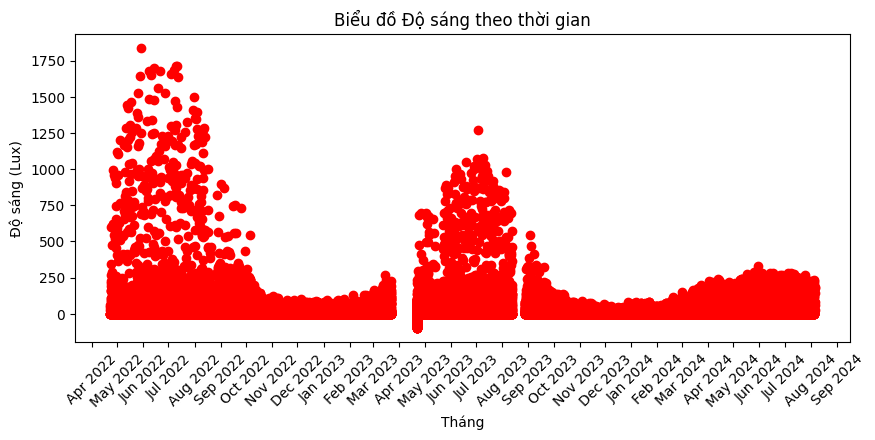

In [14]:
luminosity_rows = df[
    df["datatype"] == "luminosity"
]

time, value = luminosity_rows["epochtime"], luminosity_rows["value"]
lineplot(time, value, {"datatype": "Độ sáng", "unit": "Lux"})

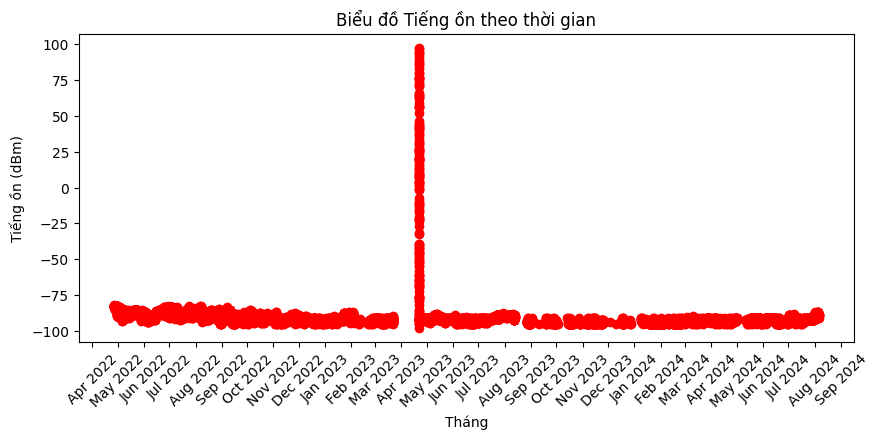

In [15]:
acoustic_rows = df[
    df["datatype"] == "acoustic"
]

time, value = acoustic_rows["epochtime"], acoustic_rows["value"]
lineplot(time, value, {"datatype": "Tiếng ồn", "unit": "dBm"})

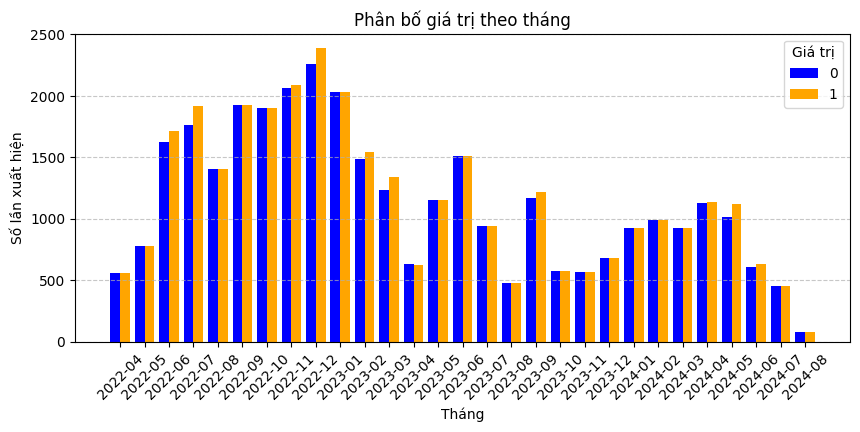

In [16]:
motion_rows = df[
    df["datatype"] == "motion"
]

barplot(motion_rows["epochtime"], motion_rows["value"])

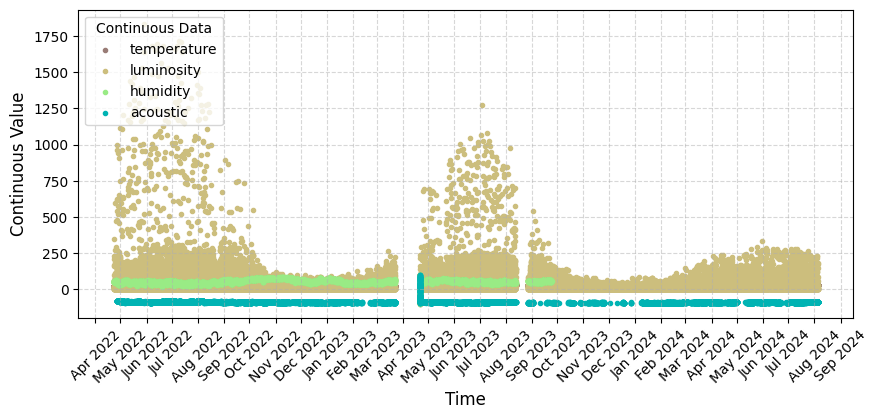

In [17]:
multi_scatterplot(df)

In [18]:
print(luminosity_rows["value"].describe())
print("-------------------------------------")
print(temperature_rows["value"].describe())

count    26936.000000
mean        47.216974
std        122.659029
min        -99.598237
25%          0.000000
50%         10.000000
75%         46.000000
max       1837.000000
Name: value, dtype: float64
-------------------------------------
count    39747.000000
mean        22.875191
std          7.680747
min        -99.779585
25%         19.800000
50%         22.600000
75%         26.200000
max         99.531875
Name: value, dtype: float64


In [19]:
print(humidity_rows["value"].describe())
print("-------------------------------------")
print(acoustic_rows["value"].describe())

count    9458.000000
mean       51.587433
std        15.395766
min       -99.960229
25%        44.000000
50%        51.500000
75%        60.000000
max        97.780843
Name: value, dtype: float64
-------------------------------------
count    12680.000000
mean       -89.791078
std         11.999480
min        -97.928178
25%        -92.333333
50%        -91.562500
75%        -89.500000
max         97.357523
Name: value, dtype: float64


Có thể thấy:

|Loại dữ liệu|Số mẫu dữ liệu|Tháng bắt đầu thu dữ liệu|Tháng kết thúc thu dữ liệu|
|---|---|---|---|
|`Humidity`|9458|4/2022|10/2023|
|`Temperature`|39747|4/2022|9/2024|
|`Luminosity`|26936|4/2022|9/2024|
|`Acoustic`|12680|4/2023|9/2024|
|`Motion`|66439|4/2022|9/2024|

Lưu ý:
- Khoảng thời gian thu dữ liệu của các loại dữ liệu chủ yếu bắt đầu từ 4/2022 đến 10/2024, chỉ mỗi loại dữ liệu `Humidity` chỉ được thu đến 10/2023

Vì vậy, chỉ lấy dữ liệu trong khoảng có đủ toàn bộ loại dữ liệu: 5/2022 - 8/2023

- Có 2 khoảng thời gian trống mà không có loại dữ liệu nào được thu

Vì vậy, tách đoạn dữ liệu thành 3 khoảng thời gian thu liên tục

In [20]:
start_date = "2022-05-01"
end_date = "2023-08-31"

filtered_acoustic = df[
    (df["epochtime"] >= start_date) & 
    (df["epochtime"] <= end_date)
][["epochtime", "datatype", "value", "control"]].reset_index(drop = True)

filtered_acoustic.head(2)

,epochtime,datatype,value,control
0,2022-05-01 00:45:00,luminosity,0.00,indirect
1,2022-05-01 00:45:00,humidity,46.61,indirect


### 2.3.2. Kiểm tra trung bình các khoảng thời gian giữa 2 lần đo liên tiếp

Kiểm tra trung bình các khoảng thời gian giữa 2 lần đo liên tiếp nhằm xác định timestamp và số mẫu dữ liệu trong một timestamp.

In [21]:
def avg_time_diff(df, plot = False):
    epochtimes = sorted(df["epochtime"].unique())

    time_diffs_min = []
    for i in range(len(epochtimes) - 1):
        interval = (epochtimes[i + 1] - epochtimes[i]).total_seconds() / 60
        if interval > 20000:
            print(f"Thời gian từ {epochtimes[i]} đến {epochtimes[i + 1]}: {interval / (60 * 24):.2f} ngày")
            continue

        time_diffs_min.append(interval)

    avg_interval = np.mean(time_diffs_min)

    print(f"Trung bình khoảng cách giữa các 2 lần đo dữ liệu: {avg_interval:.2f} phút")

    if plot:
        boxplot(pd.DataFrame(time_diffs_min, columns = ["Giữa 2 lần đo (phút)"]))

Thời gian từ 2023-03-22 13:55:17 đến 2023-04-21 09:53:10: 29.83 ngày
Thời gian từ 2023-08-12 17:41:24 đến 2023-08-27 10:43:37: 14.71 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 7.86 phút


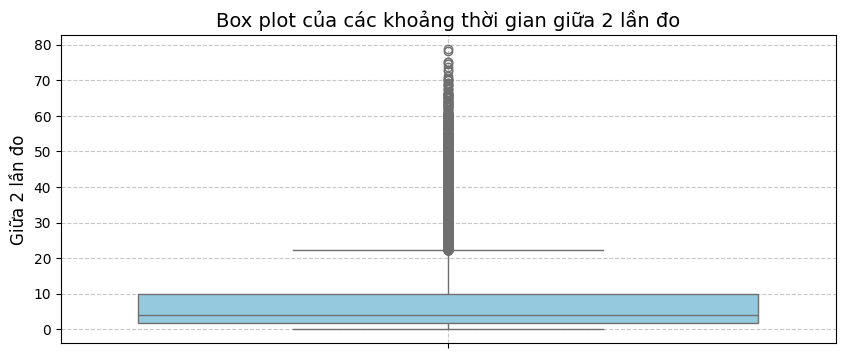

In [22]:
avg_time_diff(filtered_acoustic, True)

In [23]:
print(f"HUMIDITY")
avg_time_diff(filtered_acoustic[
    filtered_acoustic["datatype"] == "humidity"
])
print(f"----------------------------------------------")
print(f"LUMINOSITY")
avg_time_diff(filtered_acoustic[
    filtered_acoustic["datatype"] == "luminosity"
])
print(f"----------------------------------------------")
print(f"ACOUSTIC")
avg_time_diff(filtered_acoustic[
    filtered_acoustic["datatype"] == "acoustic"
])
print(f"----------------------------------------------")
print(f"TEMPERATURE")
avg_time_diff(filtered_acoustic[
    filtered_acoustic["datatype"] == "temperature"
])
print(f"----------------------------------------------")
print(f"MOTION")
avg_time_diff(filtered_acoustic[
    filtered_acoustic["datatype"] == "motion"
])
print(f"----------------------------------------------")

HUMIDITY
Thời gian từ 2023-03-22 13:35:00 đến 2023-04-21 09:53:10: 29.85 ngày
Thời gian từ 2023-08-12 17:00:00 đến 2023-08-27 10:55:00: 14.75 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 72.20 phút
----------------------------------------------
LUMINOSITY
Thời gian từ 2023-03-22 13:35:00 đến 2023-04-21 09:53:10: 29.85 ngày
Thời gian từ 2023-08-12 17:05:00 đến 2023-08-27 10:55:00: 14.74 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 35.82 phút
----------------------------------------------
ACOUSTIC
Thời gian từ 2023-03-22 13:40:00 đến 2023-04-21 09:53:10: 29.84 ngày
Thời gian từ 2023-08-12 17:30:00 đến 2023-08-27 11:30:00: 14.75 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 72.05 phút
----------------------------------------------
TEMPERATURE
Thời gian từ 2023-03-22 13:40:00 đến 2023-04-21 09:53:10: 29.84 ngày
Thời gian từ 2023-08-12 17:30:00 đến 2023-08-27 10:55:00: 14.73 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 24.51 phút
----------------------

Có thể thấy 2 khoảng thời gian trống mà không loại dữ liệu nào được thu bao gồm:

- Từ ngày `22/3/2023` đến `21/4/2023`: xấp xỉ 30 ngày
- Từ ngày `12/8/2023` đến `27/8/2023`: xấp xỉ 15 ngày

Đây là điểm cắt chuỗi thời gian tổng thành 3 chuỗi thời gian nhỏ hơn

|Loại dữ liệu|Thời gian đo trung bình (phút)|
|---|---|
|Humidity|72.2|
|Luminosity|35.82|
|Acoustic|72.05|
|Temperature|24.51|
|Motion|13.65|

Để đảm bảo mỗi timestamp có ít nhất 1 giá trị của mỗi datatype, cần chọn timestamp = max(thời gian đo trung bình của datatypes)

Vì vậy chọn: `Timestamp` = 90 phút

### 2.3.3. Data segmentation


In [24]:
start_date = "2022-05-01"

first_start_gap = "2023-3-21"
first_end_gap = "2023-4-22"

second_start_gap = "2023-8-11"
second_end_gap = "2023-8-28"

end_date = "2023-08-31"

first_gap = pd.date_range(start = start_date, end = first_start_gap, freq = "90min")
second_gap = pd.date_range(start = first_end_gap, end = second_start_gap, freq = "90min")
third_gap = pd.date_range(start = second_end_gap, end = end_date, freq = "90min")

timestamps = first_gap.union(second_gap).union(third_gap)
timestamps

DatetimeIndex(['2022-05-01 00:00:00', '2022-05-01 01:30:00',
               '2022-05-01 03:00:00', '2022-05-01 04:30:00',
               '2022-05-01 06:00:00', '2022-05-01 07:30:00',
               '2022-05-01 09:00:00', '2022-05-01 10:30:00',
               '2022-05-01 12:00:00', '2022-05-01 13:30:00',
               ...
               '2023-08-30 10:30:00', '2023-08-30 12:00:00',
               '2023-08-30 13:30:00', '2023-08-30 15:00:00',
               '2023-08-30 16:30:00', '2023-08-30 18:00:00',
               '2023-08-30 19:30:00', '2023-08-30 21:00:00',
               '2023-08-30 22:30:00', '2023-08-31 00:00:00'],
              dtype='datetime64[ns]', length=7011, freq=None)

In [25]:
segmented_data = []
for i in tqdm(range(len(timestamps) - 1)):
    start = timestamps[i]
    end = timestamps[i + 1]

    segment = filtered_acoustic[
        (filtered_acoustic["epochtime"] >= start) &
        (filtered_acoustic["epochtime"] < end)
    ]

    if segment.empty:
        print(f"{start} - {end} không có dữ liệu")
        continue
  
    segmented_data.append(segment)

100%|██████████| 7010/7010 [00:04<00:00, 1551.68it/s]


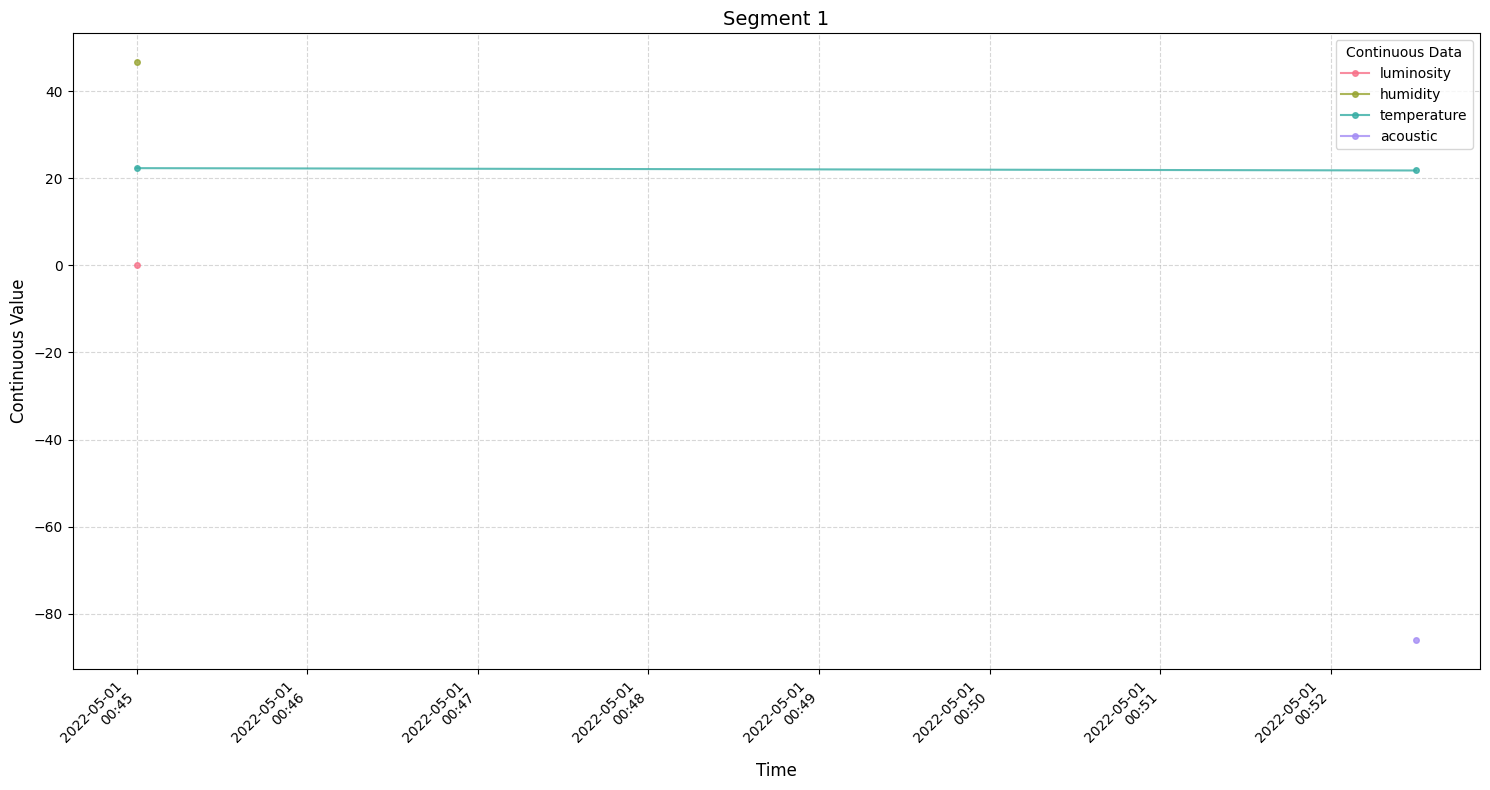

In [26]:
multi_lineplot(segmented_data[0], "Segment 1")

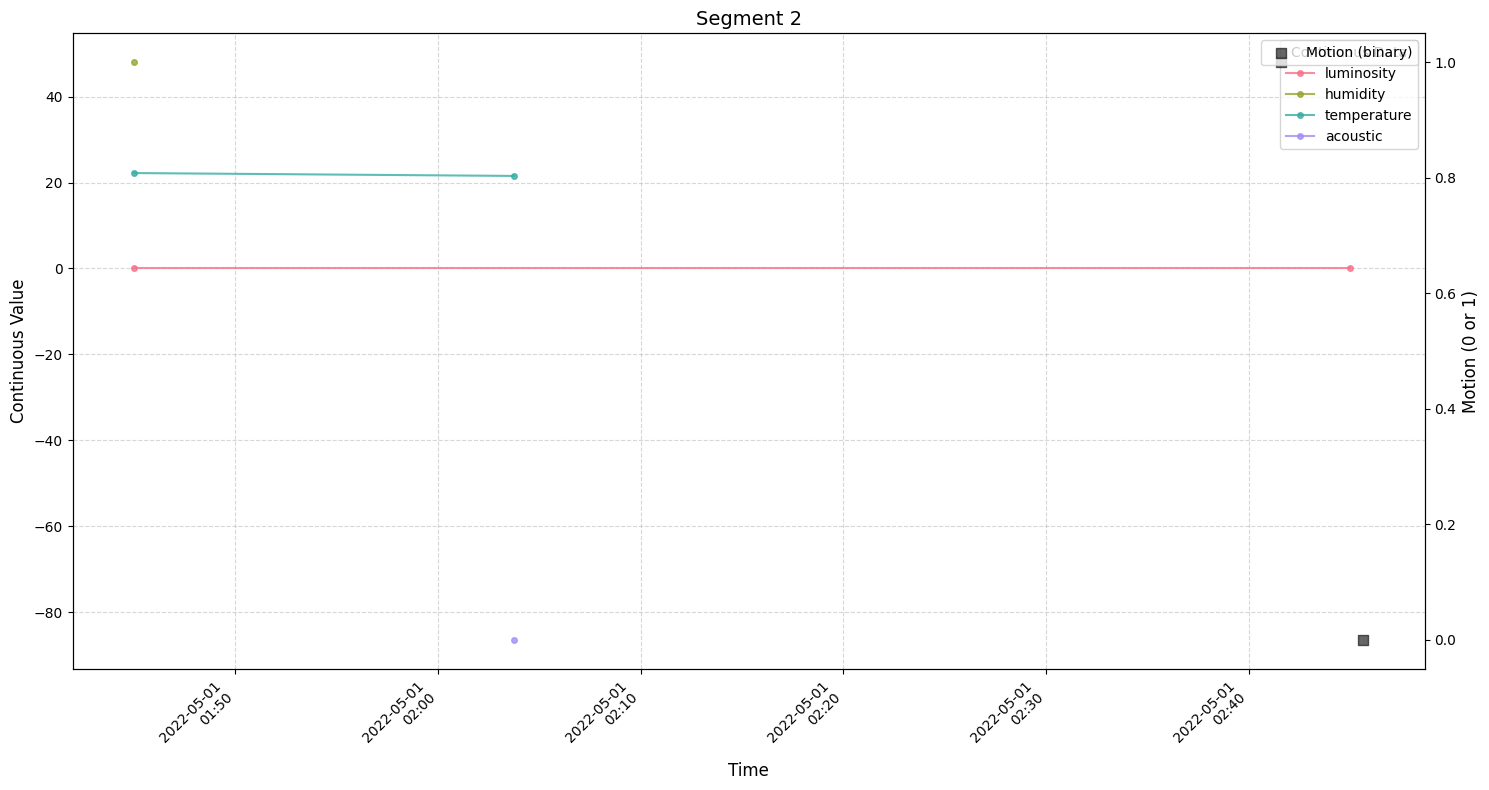

In [27]:
multi_lineplot(segmented_data[1], "Segment 2")

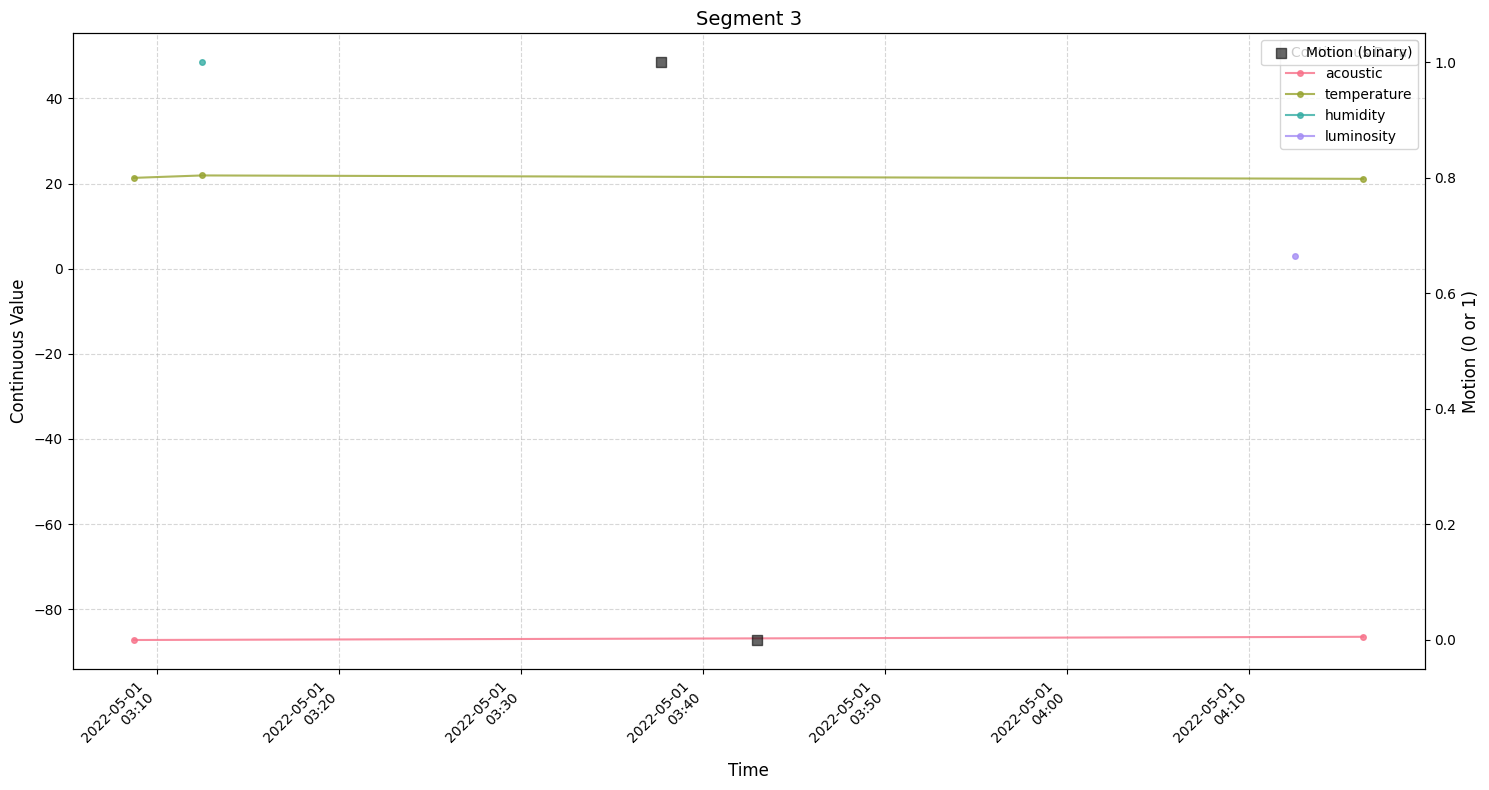

In [28]:
multi_lineplot(segmented_data[2], "Segment 3")